# House Prices - Advanced Regression Techniques
## Exploratory Data Analysis
## Trevor Johnson

<br>

### Goal:
Predict sales price for each house (`SalePrice`). RMSE on log(pred) - log(actual) will be the evaluation metric. Final submission dataset should contain only the two fields `ID` and `SalePrice`. 

# Setups

Load libraries and read in the data

In [18]:
# libraries
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
import matplotlib.pyplot as plt

# modeling setups
from patsy import dmatrices
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# linear modeling
import statsmodels.api as sm
from statsmodels.formula.api import glm 
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [19]:
!pwd

/Users/tj/Desktop/data/housing


In [20]:
# set directory and read in the data
os.chdir("/Users/tj/Desktop/data/housing")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
sample = pd.read_csv("sample_submission.csv")

# Initial Exploration

Size of training and testing data.

In [21]:
print("train shape: {}".format(train.shape))
print("test shape: {}".format(test.shape))

train shape: (1460, 81)
test shape: (1459, 80)


Check for missing values. Some variables have mostly missing values.

In [22]:
train.isnull().sum()[train.isnull().sum() != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [23]:
# deal with missing values, can alter this later

def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df

train = na_clean(train)
test = na_clean(test)


In [24]:
# no more missing values!
print("Missing values in train: {}".format(train.isnull().sum().sum()))
print("Missing values in test: {}".format(test.isnull().sum().sum()))

Missing values in train: 0
Missing values in test: 0


In [25]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    69.863699   10516.828082     6.099315   
std     421.610009    42.300571    22.027677    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    60.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    79.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.117123   443.639726  ...   
std       1.112799    30.202904     20.645407   180.731373   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   164.250000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [26]:
# some data cleaning

# rename fields
#train = train.rename(columns = {"1stFlrSF": "FirstFlrSF", "2ndFlrSF": "SecondFlrSF", "3SsnPorch": "ThreeSeasonPorchSF"})
#test = test.rename(columns = {"1stFlrSF": "FirstFlrSF", "2ndFlrSF": "SecondFlrSF", "3SsnPorch": "ThreeSeasonPorchSF"})

## Data Visualization

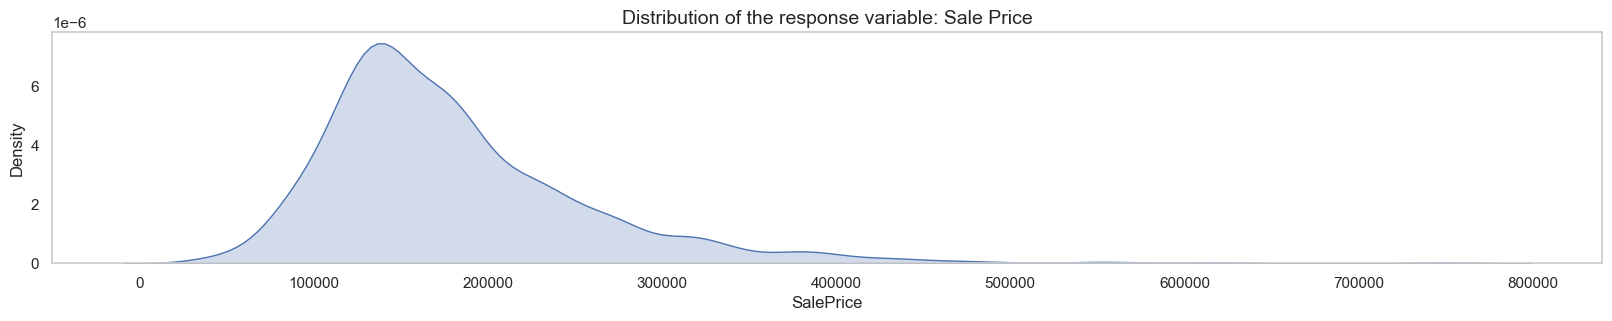

In [27]:
sns.set(rc = {'figure.figsize':(20,3)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.kdeplot(data=train, x="SalePrice", bw_adjust=.8, fill=True)\
    .set_title("Distribution of the response variable: Sale Price", size=14)
print("")

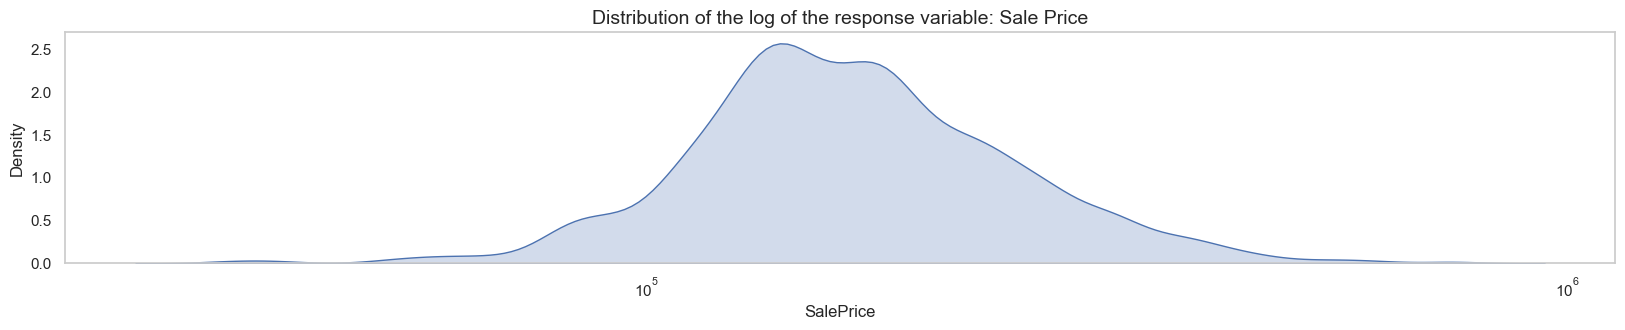

In [28]:
sns.set(rc = {'figure.figsize':(20,3)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.kdeplot(data=train, x="SalePrice", bw_adjust=.8, fill=True, log_scale=True)\
    .set_title("Distribution of the log of the response variable: Sale Price", size=14)
print("")

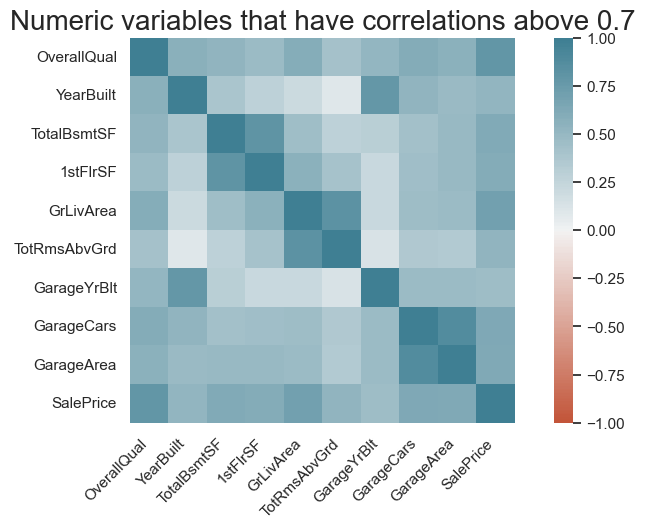

In [29]:
# get correlations of all numeric vars
corr_orig = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].corr()

# there are 38 of them, let's look at a subset to only show the ones w/ correlations above some threshold
threshold = .7
bool_list = [sum((corr_orig.iloc[i,:] < 1) & (corr_orig.iloc[i,:] > threshold)) > 0 for i in range(corr_orig.shape[0])]
corr = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].loc[:, bool_list].corr()

# plot the results
sns.set()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Numeric variables that have correlations above {:.1f}".format(threshold), fontdict = {"fontsize": 20})

plt.gcf().set_size_inches(10, 5)
print("")

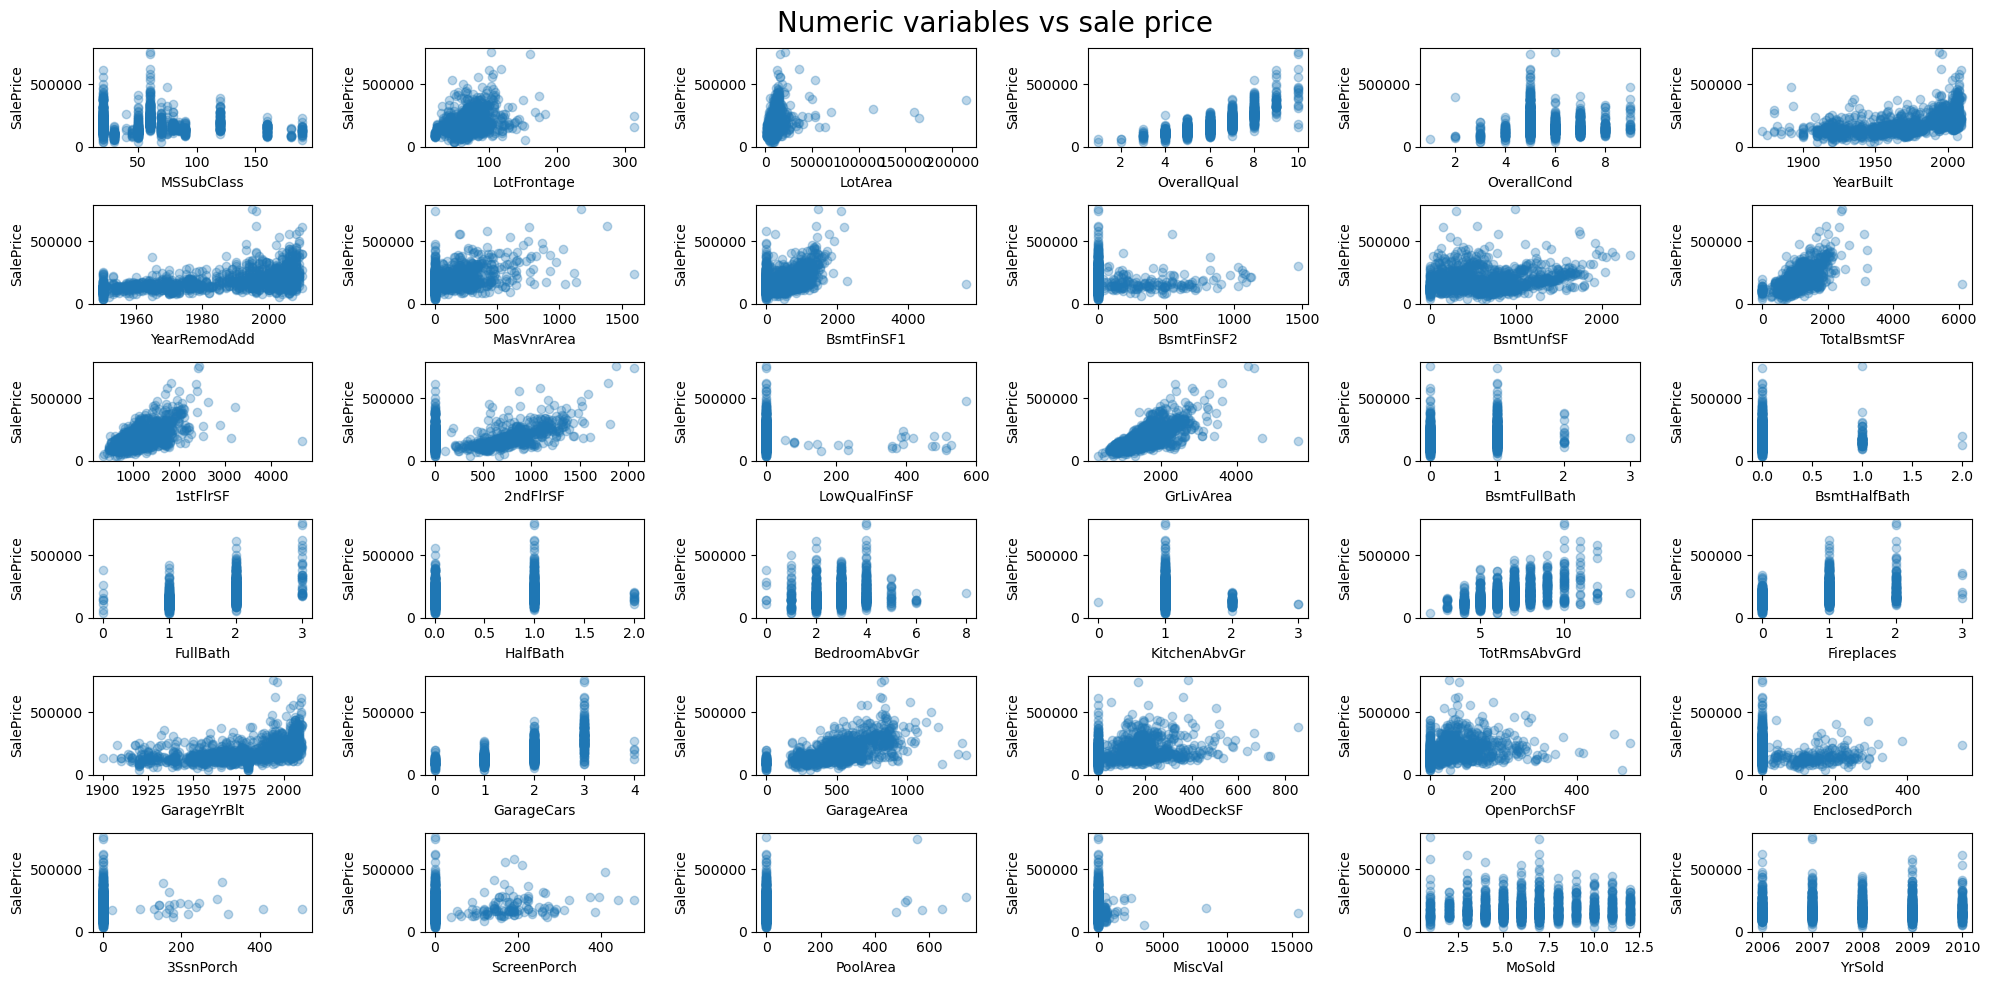

In [30]:
# scatter plots of all num vars w/ response var
num_vars = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))]
num_vars = num_vars.drop(columns = ["Id"])

# plot in 6x6 grid to plot the 36 num vars against SalePrice
num_rows = 6
num_cols = 6
plt.style.use('default')
fig, ax = plt.subplots(num_rows, num_cols, figsize = (20, 10))

col_i = 0
for i in range(num_rows):
    for j in range(num_cols):
        if (num_vars.columns[col_i] == "SalePrice"):
            pass 
        else:
            ax[i][j].scatter(num_vars.iloc[:, col_i], num_vars['SalePrice'], alpha = .3)
            ax[i][j].set_xlabel(num_vars.columns[col_i])
            ax[i][j].set_ylabel("SalePrice")
            
            col_i += 1

fig.suptitle("Numeric variables vs sale price".format(col_i), size=20)
fig.tight_layout()
print("")

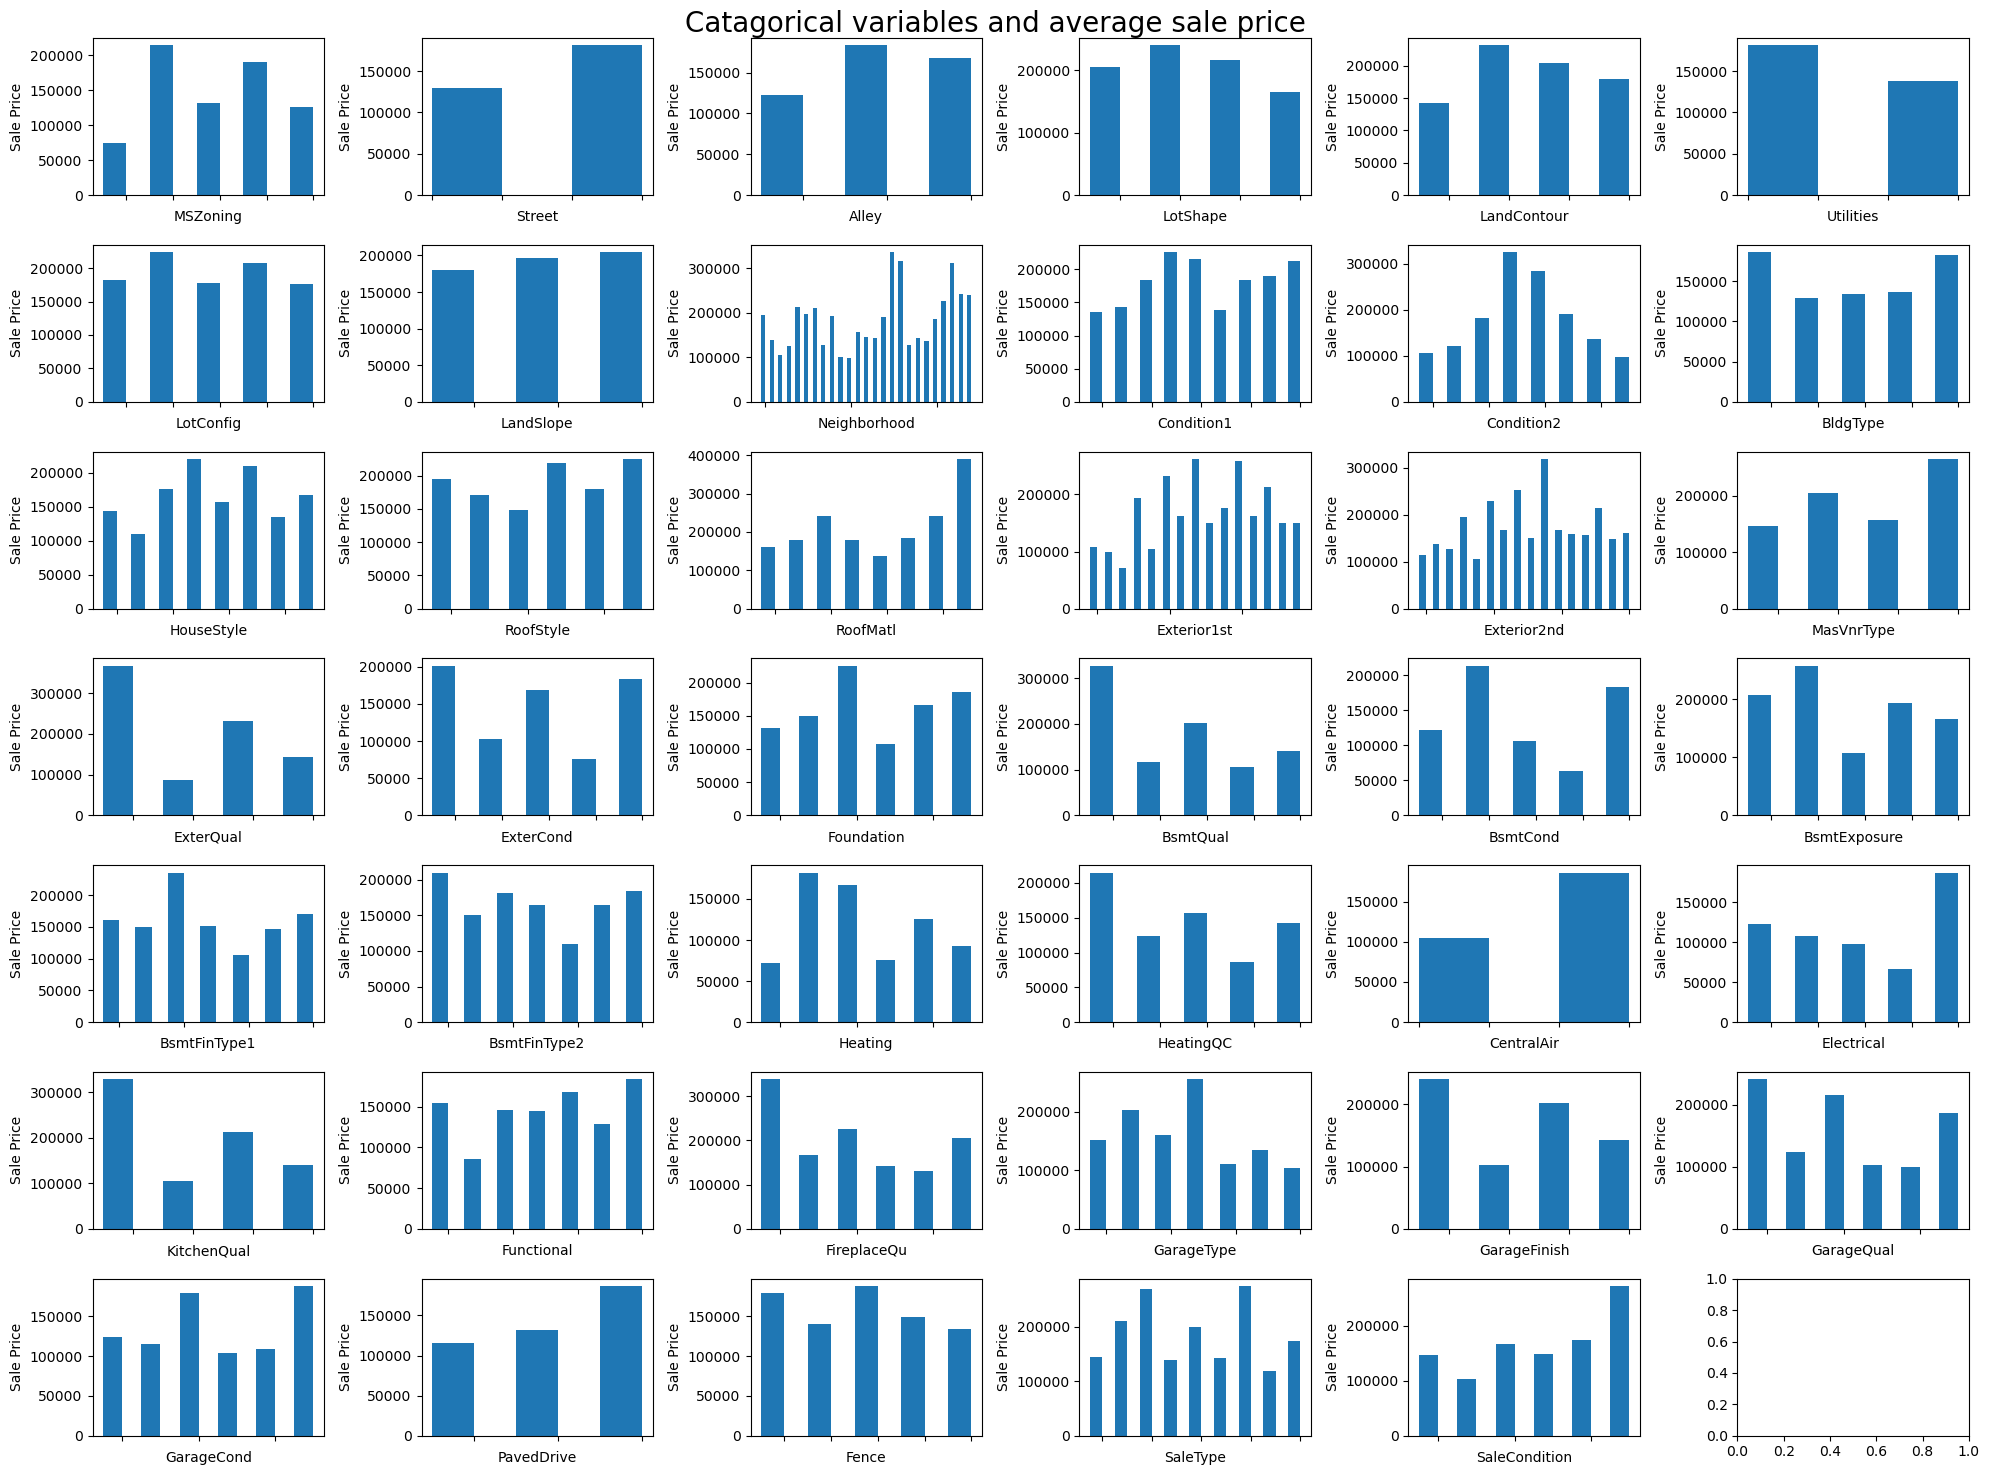

In [31]:
# categorical exploration
cat_vars = pd.concat([train.loc[:, train.dtypes == type(train.dtypes[2])], train.SalePrice], axis = 1)
n_cols = cat_vars.shape[1]

# plots
num_row = 7
num_col = 6
fig, ax = plt.subplots(num_row, num_col, figsize = (20, 15))

count_k = 0
for i in range(num_row):
    for j in range(num_col):

        # each df
        var_i = cat_vars.columns[count_k]

        if var_i == "SalePrice":
            pass 
        else:

            df_i = pd.DataFrame(cat_vars.groupby(var_i)['SalePrice'].mean())
            df_i.reset_index(inplace = True)

            # create plot i
            x = np.arange(df_i.shape[0])
            width = .5

            # set the bars
            ax[i][j].bar(x - width / 2, df_i.SalePrice, width, label = "x")
            ax[i][j].set_xlabel(var_i)
            ax[i][j].set_ylabel("Sale Price")
            #ax[i][j].set_xticklabels(df_i[var_i], rotation = 90)
            ax[i][j].set_xticklabels("")
            
            count_k += 1

fig.suptitle("Catagorical variables and average sale price", size=20)
fig.tight_layout()

print("")

# Feature Engineering

In [32]:
#train.groupby("Utilities").agg(avg_sale_price = ("SalePrice", lambda x: np.round(np.mean(x), 0)), count = ("SalePrice", "count"))
#train.groupby("PoolArea").agg(avg_sale_price = ("SalePrice", lambda x: np.round(np.mean(x), 0)), count = ("SalePrice", "count"))

In [33]:
# keep adapting this formula to change how we feature engineer
def feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''

    # num features to just binarize b/c few houses have the feature
    df["SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df['LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df['MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))
    df['MSSubClass'] = df['MSSubClass'].astype("object")

    # deciding to drop a few features for various reasons
    vars_to_drop = [
        "LowQualFinSF", # hardly any variation
        "LandSlope", # not much variation
        "PoolArea", # binarized above
        "MiscVal", # not much variation
        "Utilities", # only 1 obs in training data different from regular
        #"KitchenAbvGr" # hardly any variation. But, Deva included in lm's so including it now.
        ]
    df.drop(columns=vars_to_drop, inplace=True) 

    # adding a remodeled feature
    df['Remodeled'] = (df.YearRemodAdd-df.YearBuilt) == 0

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df['Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # simplify the bathrooms variable
    df['Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)

    # get log of sale price which will be our actual response variable
    if test_data:
        pass 
    else:
        df['LogSalePrice'] = np.log(df.SalePrice)

    return df

# run function on test and train
train = feature_eng(train)
test = feature_eng(test, test_data=True)

In [34]:
# function to onehot encode, standardize, and normalize
def transform(df, onehotencode=True, standardize=True, scale=True):
    '''input either train/test data and this function will
    (1) onehot encode all categorical features
    (2) standardize every feature
    (3) normalize every feature between [0, 1]
    '''
    # onehot encode
    if onehotencode:
        df = pd.get_dummies(df)

    # standardize
    if standardize:
        df_standard = StandardScaler().fit_transform(df)
        df = pd.DataFrame(data = df_standard, columns = df.columns)
    
    # scale 
    if scale:
        df_scale = MinMaxScaler().fit_transform(df)
        df = pd.DataFrame(data = df_scale, columns = df.columns)
    
    return df


# run function on test and train
train_transformed = pd.concat([train.loc[:, ['Id', "LogSalePrice"]], transform(train.drop(columns = ["Id", "SalePrice", "LogSalePrice"]))], axis=1)
test_transformed = pd.concat([test['Id'], transform(test.drop(columns = "Id"))], axis=1)

# Modeling

## Lasso

In [35]:
# start w/ lasso regression to narrow down the variable list

X = train_transformed.drop(columns=['Id', 'LogSalePrice'])
y = train_transformed['LogSalePrice']

# lasso parameters
lasso = Lasso(tol = .0001, max_iter = 5000)

# cross validate for optimal alpha weight
grid = {'alpha': np.arange(0.01, .2, .01)}

# set up the search
gscv = GridSearchCV(
    estimator = lasso, 
    param_grid = grid, 
    n_jobs = -1, 
    cv = 5
    )

# cross validate for optimal alpha
results = gscv.fit(X, y)

# optimal alpha level
print("Optimal alpha level: {}".format(results.best_params_['alpha'])) # 0.01

# plug in this alpha parameter for final lasso regression
lasso_final = Lasso(alpha = results.best_params_['alpha'], tol = .0001, max_iter = 5000)
lasso_final.fit(X, y)

# see coefficents that are greater than some threshold
coef_threshold = 0
lasso_results_df = pd.DataFrame({
    'final_features': np.array(X.columns)[np.array(lasso_final.coef_) != coef_threshold],
    'final_coefs': np.array(lasso_final.coef_)[np.array(lasso_final.coef_) != coef_threshold]
})
print(lasso_results_df) 

Optimal alpha level: 0.01
         final_features   final_coefs
0           OverallQual  4.965756e-01
1          YearRemodAdd  9.716269e-02
2          TotRmsAbvGrd  8.978308e-02
3            GarageCars  2.401793e-01
4             Bathrooms  1.766994e-01
5           MSZoning_RL  5.596954e-02
6           MSZoning_RM -2.489636e-02
7         BldgType_1Fam  1.716548e-02
8     HouseStyle_2Story  6.883419e-03
9       RoofStyle_Gable -6.820888e-03
10      MasVnrType_None -1.862002e-02
11         ExterQual_TA -6.403960e-02
12     Foundation_PConc  2.671931e-02
13          BsmtQual_Ex  6.448779e-02
14      BsmtExposure_Gd  2.301560e-02
15     BsmtFinType1_GLQ  3.471501e-02
16     BsmtFinType1_Unf -4.892314e-04
17         HeatingQC_Ex  3.630199e-02
18         CentralAir_N -1.799582e-02
19         CentralAir_Y  2.799979e-16
20       KitchenQual_Ex  2.794636e-02
21       KitchenQual_TA -4.503855e-02
22  FireplaceQu_Missing -1.393068e-01
23    GarageType_Attchd  4.458258e-02
24     GarageFinish_Fin 

## GLM with Gamma family

In [36]:
# Now w/ narrowed down variable list, build a glm w/ gamma family due to sale price dist shape
lasso_vars_list = list(lasso_results_df['final_features'])
lasso_vars_list = "+".join(lasso_vars_list)

glm_formula = "LogSalePrice~" + lasso_vars_list
fit_glm = glm(glm_formula, data = train_transformed, family = sm.families.Gamma(sm.families.links.log))
fit_glm = fit_glm.fit()
print(fit_glm.summary())

<ipython-input-36-6f351260baf3>:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  fit_glm = glm(glm_formula, data = train_transformed, family = sm.families.Gamma(sm.families.links.log))


                 Generalized Linear Model Regression Results                  
Dep. Variable:           LogSalePrice   No. Observations:                 1460
Model:                            GLM   Df Residuals:                     1434
Model Family:                   Gamma   Df Model:                           25
Link Function:                    log   Scale:                      0.00016647
Method:                          IRLS   Log-Likelihood:                 570.19
Date:                Fri, 12 Nov 2021   Deviance:                      0.26954
Time:                        14:21:09   Pearson chi2:                    0.269
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.082e+10   3

In [37]:
train_2 = train.drop(columns=['Id','SalePrice', 'LogSalePrice'])

## Random forest with cross validation

In [38]:
# preprocess the data
train_dummies = pd.get_dummies(train)

# create the train and test splits
dev_train, dev_test = train_test_split(train_dummies, test_size=0.3, random_state=1)

# specify model
rf = RandomForestRegressor(bootstrap=True, max_features='auto')

# run grid search on range of values
grid = {
    "n_estimators": np.arange(100, 1001, 100),
    'max_depth': np.arange(10, 101, 5),
    'min_samples_split': [2, 5, 7],
}

# put our parameters into GridSearch
gscv = GridSearchCV(
    estimator = rf, 
    param_grid = grid, 
    n_jobs = -1, 
    cv = 3)

# run the search:
# this took 26 min to run. 
# re-run if you want
#results = gscv.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

# check out the best parameters
print(results.best_params_)
# {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 900}

{'alpha': 0.01}


In [40]:
# finally, run model on best parameters
rf_reg = RandomForestRegressor(
    n_estimators = 900,
    max_depth = 25,
    max_features = 'auto',
    min_samples_split = 2,  
    bootstrap = True, 
    )

# fit the model
rf_reg.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

# evaluate it's performance on the unforseen testing set
yhat = rf_reg.predict(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']))
resids = yhat - dev_test.LogSalePrice

# evaluate rmse and mae on the testing data
print("RMSE: " + str(round(np.mean(resids**2)**.5,4)))
# MAE: 0.0999
# RMSE: 0.154

RMSE: 0.1537


In [41]:
# score on train
rf_train_score = rf_reg.score(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)
print("Score on train: {:.3f}".format(rf_train_score))

# score on test/dev
rf_dev_score = rf_reg.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice)
print("Score on test: {:.3f}".format(rf_dev_score))

Score on train: 0.981
Score on test: 0.875


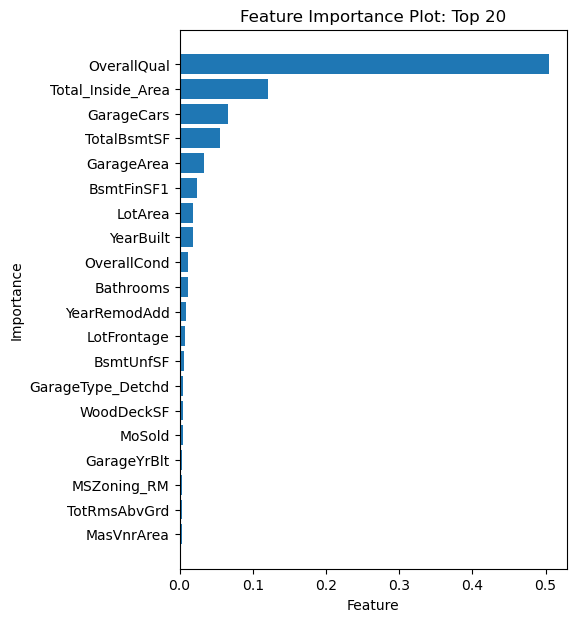

In [42]:
# variable importance plot
var_imp = pd.DataFrame({
    'feature': dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']).columns,
    'importance': rf_reg.feature_importances_
})
var_imp.sort_values("importance", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(5, 7))
topn = 20
ax.barh(var_imp.head(topn).feature, var_imp.head(topn).importance)
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.set_title("Feature Importance Plot: Top {}".format(topn))
ax.invert_yaxis()
print("")


In [ ]:
# boosted tree

In [ ]:
# neural net??

In [ ]:
# ensemble

In [ ]:
# any other model?

## Best Model